# Contexte du projet


Une équipe médicale souhaite tester l’apport de l’intelligence artificielle dans **le diagnostic automatisé de la pneumonie à partir de radios thoraciques.** Elle a besoin d’un prototype fonctionnel (Proof of Concept) permettant de démontrer la faisabilité d’**un système de classification binaire d’images médicales**.

>Le problème posé consiste à réutiliser un modèle de vision par ordinateur **pré-entraîné (type CNN)** pour l’adapter au contexte médical, sans repartir d’un entraînement complet.

> Dans une logique de mise en production à moyen terme, il est également attendu de documenter et tracer les expérimentations réalisées. L’usage de **MLflow** est proposé pour initier cette démarche, en assurant le suivi des performances, la traçabilité des essais et la gestion des versions de modèles dans une perspective MLOps.

# Modalités d'évaluation
Évaluation individuelle à partir du livrable (notebook). 
Le barème porte sur 
- **la qualité de la démarche (pertinence des choix, rigueur des étapes, clarté des explications),** 
- **la bonne compréhension du transfert learning,**
- **et l’initiation à MLflow (usage basique)**.

# Livrables
Un **lien GitHub** contenant les travaux réalisés, notamment un notebook complet, structuré, lisible et commenté, incluant :
- Préparation et exploration du dataset
- Mise en place du modèle pré-entraîné et adaptation
- Entraînement, évaluation (matrice de confusion, courbes, métriques etc...)
- Suivi des expériences via MLflow
- Le dépôt du code sur GitHub avec les travaux réalisé (notebook) avec un README synthétique

# Critères de performance
- Le notebook couvre toutes **les étapes clés de la démarche** (pré-traitement, modélisation, évaluation)
- Les **choix techniques sont justifiés** avec clarté et cohérence
- Le **modèle est adapté** de manière correcte à la tâche de classification binaire
- L’**évaluation du modèle est rigoureuse** (métriques pertinentes, commentaires clairs)
- La première utilisation de **MLflow est fonctionnelle et comprise** (log simple de paramètres ou de métriques)
- Le **code est structuré, commenté, exécutable**
- *La performance du modèle n'est pas un critère de performances, seul compte la démarche, la compréhension et donc la clarté des notes dans le le notebook*

----

# 1. Chargement des bibliothèques nécessaires

 - Création du fichier requirements.txt contenant les bibliothèques à installer
 - Création d'un environnment virtuel `python -m venv .venv` et l'activer ` .\.venv\Scripts\Activate.ps1`
 - Installer les bibliothèques `pip install - requirements.txt` 
 - choisir le dossier .venv dans "Python: Select interpreter" (Command Palette)
 (venv contenant python 3.10 compatible avec tensorflow)
 - installer ipykernel pour executer

In [1]:
import os  # os pour manipuler des dossiers et fichiers
import numpy as np # np pour manipuler des vecteurs et matrices
import pandas as pd # pd pour traiter des dataframe et visualiser des figures
import seaborn as sns # pd pour visualiser des figures

import mlflow #  pour documenter et tracer les expérimentations réalisées.
import mlflow.tensorflow
# DL Lib
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense 

import matplotlib.pyplot as plt  #  pour visualiser des figures
from sklearn.metrics import confusion_matrix, classification_report # pd pour évaluer le modèle
import cv2
#from tensorflow import keras
#from keras.models import Model
#from keras.layers import Dense
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

# 2. Préparation et exploration du dataset

[[[ 24  24  24]
  [ 20  20  20]
  [ 19  19  19]
  [ 17  17  17]
  [ 17  17  17]
  [ 28  28  28]
  [ 56  56  56]
  [ 58  58  58]
  [ 64  64  64]
  [ 65  65  65]
  [ 72  72  72]
  [ 74  74  74]
  [ 80  80  80]
  [ 86  86  86]
  [ 90  90  90]
  [ 90  90  90]
  [ 92  92  92]
  [ 91  91  91]
  [ 99  99  99]
  [ 98  98  98]
  [100 100 100]
  [ 99  99  99]
  [102 102 102]
  [102 102 102]
  [107 107 107]
  [107 107 107]
  [110 110 110]
  [115 115 115]
  [111 111 111]
  [134 134 134]
  ...
  [ 84  84  84]
  [ 88  88  88]
  [ 88  88  88]
  [ 93  93  93]
  [ 91  91  91]
  [ 93  93  93]
  [ 98  98  98]
  [ 98  98  98]
  [ 98  98  98]
  [ 99  99  99]
  [100 100 100]
  [115 115 115]
  [147 147 147]
  [168 168 168]
  [155 155 155]
  [140 140 140]
  [138 138 138]
  [133 133 133]
  [133 133 133]
  [138 138 138]
  [152 152 152]
  [166 166 166]
  [138 138 138]
  [ 96  96  96]
  [ 96  96  96]
  [ 94  94  94]
  [ 95  95  95]
  [ 95  95  95]
  [ 94  94  94]
  [ 95  95  95]]

 [[ 22  22  22]
  [ 22  22  22]


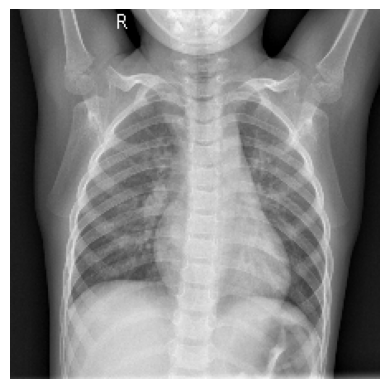

Shape (dimensions)    : (224, 224, 3)
Type des valeurs      : uint8


In [2]:
# On charge une image depuis un chemin local, l’image est chargé en 1 canal (valeur de pixel de 0 à 255)
img = cv2.imread("data/train/NORMAL/IM-0115-0001.jpeg", cv2.IMREAD_GRAYSCALE)
# Convert to 3 channels
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Now shape is (H, W, 3)
# Resize to model input size (e.g., 224x224)
resized_img = cv2.resize(img_rgb, (224, 224))
# Observer l'image sous forme de matrice
print(resized_img)

# Visualisation de l'image
plt.imshow(resized_img, cmap="gray")
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image
print(f"Shape (dimensions)    : {resized_img.shape}")
print(f"Type des valeurs      : {resized_img.dtype}")

## Chargement des données

In [3]:
def get_train_val(base_path: str):
    X = []  # liste pour stocker les images
    y = []  # liste pour stocker les étiquettes correspondantes

    # On parcourt les sous-dossiers du répertoire (un dossier par chiffre)
    for label in sorted(os.listdir(base_path)):
        # on ignore les fichiers qui ne sont pas des dossiers de chiffres
        if label not in ["NORMAL","PNEUMONIA"]:
            continue
        label_path = os.path.join(base_path, label)

        # On parcourt chaque image du dossier
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            # Lecture de l'image en niveaux de gris
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            # Convert to 3 channels
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Now shape is (H, W, 3)
            # Resize to model input size (e.g., 224x224)
            resized_img = cv2.resize(img_rgb, (224, 224))
            
            if img is None:
                continue  # image illisible, on passe
            X.append(resized_img)           # on ajoute l'image à la liste
            y.append(1 if label == "PNEUMONIA" else 0)    # on ajoute le label (1 if label == "PNEUMONIA" else 0)

    # Conversion des listes en tableaux NumPy
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = get_train_val("data/train")
X_val, y_val = get_train_val("data/val")

## Verification

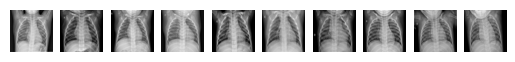

In [4]:
# Vérification des données préparées
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="grey")
    plt.axis("off")

plt.show()

## Conversion et normalisation

- La conversion des entiers (0–255) en nombres à virgule (float32)
- La normalisation des pixels entre 0.0 et 1.0

In [5]:
# Les images sont au format (224, 224). On les convertit en float pour normaliser ensuite
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_val /= 255.0

# 3. Modélisation

- Pour un transfer learning : choisir le modèle de base pré-entrainé vgg16 

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)


In [9]:
model = Model(inputs=base_model.input, outputs=predictions)


Stratégie #2 : extraction de features
On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :

In [10]:
for layer in base_model.layers:
    layer.trainable = False


# 4. Compilation

In [11]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# 5. Auto-tracking 

In [12]:
import mlflow.tensorflow


mlflow.tensorflow.autolog()
mlflow.set_experiment("Keras-TransferLearning-CNN")

<Experiment: artifact_location='file:///c:/Users/User/Desktop/DL_transfer_CNN_pneumonia/mlruns/450179581705358082', creation_time=1747901013356, experiment_id='450179581705358082', last_update_time=1747901013356, lifecycle_stage='active', name='Keras-TransferLearning-CNN', tags={}>

# 5. Fitting

In [13]:
with mlflow.start_run():
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=1,
        batch_size=32,
        shuffle=True
    )
     # log the model
    mlflow.keras.log_model(model,"model")

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5645 - loss: 0.7179

163/163 ━━━━━━━━━━━━━━━━━━━━ 1505s 9s/step - accuracy: 0.5652 - loss: 0.7173 - val_accuracy: 0.5000 - val_loss: 0.7823
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025/05/22 16:09:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/22 16:09:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [14]:
print(model.summary())  # Verify the model architecture

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,069 (56.89 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,588 (514.02 KB)

None


In [15]:
model.save('my_model.keras')


# 6. Evaluation

In [16]:
# Evaluate after training
loss, accuracy = model.evaluate(X_val,y_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5000 - loss: 0.7823
Validation Accuracy: 50.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Confusion Matrix:
 [[0 8]
 [0 8]]


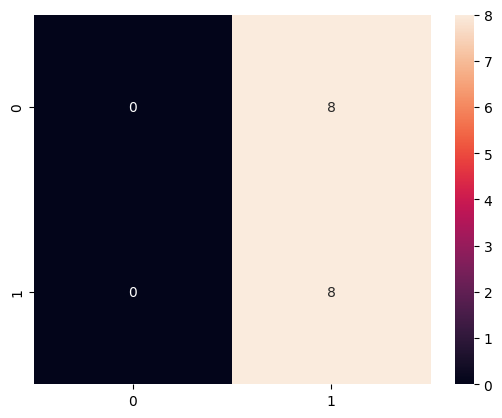

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions
y_pred_prob = model.predict(X_val)
y_pred = np.round(y_pred_prob)  # Assuming binary classification with sigmoid



# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm,annot=True)
plt.savefig('confusion_matrix.png')
print("Confusion Matrix:\n", cm)


# 7. Logging artifacts

In [18]:
# List all experiments
experiments = mlflow.search_experiments()

In [19]:
for exp in experiments:
    print(f"Experiment ID: {exp.experiment_id}, Experiment Name: {exp.name}")

Experiment ID: 151601853767064718, Experiment Name: Keras-TransferLearning-CNN-DenseNet
Experiment ID: 450179581705358082, Experiment Name: Keras-TransferLearning-CNN
Experiment ID: 253621991807162019, Experiment Name: Keras-TransferLearning-CNN-PostTraining
Experiment ID: 0, Experiment Name: Default


In [20]:

experiment_id = "450179581705358082"
# Search for runs in the specified experiment, sorted by start time in descending order
runs = mlflow.search_runs(experiment_ids=[experiment_id])

print(runs)



                             run_id       experiment_id    status  \
0  f45b97cae4bf4ceeb3f85a098cbfe3b5  450179581705358082  FINISHED   
1  01ee66f964444cc1aecf96e9074f5307  450179581705358082  FINISHED   
2  1a0c586a909d4c959a2e7e818d46329c  450179581705358082  FINISHED   
3  96034154c85c4c64a04ea4e74dcc5986  450179581705358082    FAILED   

                                        artifact_uri  \
0  file:///c:/Users/User/Desktop/DL_transfer_CNN_...   
1  file:///c:/Users/User/Desktop/DL_transfer_CNN_...   
2  file:///c:/Users/User/Desktop/DL_transfer_CNN_...   
3  file:///c:/Users/User/Desktop/DL_transfer_CNN_...   

                        start_time                         end_time  \
0 2025-05-22 13:43:43.708000+00:00 2025-05-22 14:09:37.839000+00:00   
1 2025-05-22 10:07:57.574000+00:00 2025-05-22 10:31:58.932000+00:00   
2 2025-05-22 08:26:10.162000+00:00 2025-05-22 10:39:44.464000+00:00   
3 2025-05-22 08:05:31.633000+00:00 2025-05-22 08:23:04.021000+00:00   

   metrics.loss  

In [21]:
mlflow.end_run()
# Log the artifact to the retrieved run ID
with mlflow.start_run(run_id="1a0c586a909d4c959a2e7e818d46329c"):
    mlflow.log_artifact("confusion_matrix.png")

In [22]:
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=['Normal', 'Pneumonia']))


Classification Report:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         8
   Pneumonia       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



c:\Users\User\Desktop\DL_transfer_CNN_pneumonia\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\DL_transfer_CNN_pneumonia\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\DL_transfer_CNN_pneumonia\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

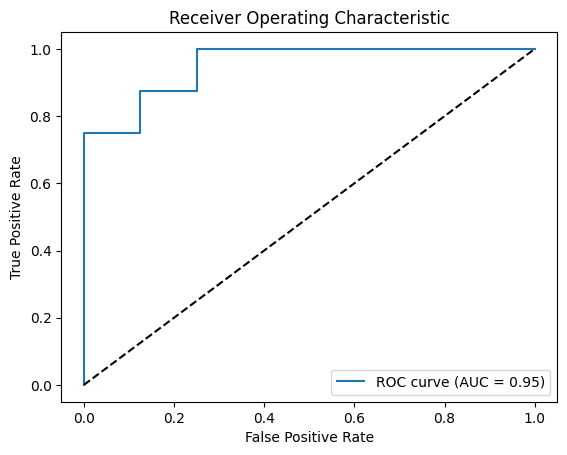

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.savefig('ROC.png')
plt.legend(loc='lower right')
plt.show()


In [24]:
# Log the artifact to the retrieved run ID
with mlflow.start_run(run_id="1a0c586a909d4c959a2e7e818d46329c"):
    mlflow.log_artifact('ROC.png')

In [25]:
# Set a tag that we can use to remind ourselves what this run was for
with mlflow.start_run(run_id="1a0c586a909d4c959a2e7e818d46329c"):
    mlflow.set_tag("Training Info", "First model")

---

## Mlflow ui
`mlflow ui `
- ouvrir http://localhost:5000